In [2]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [4]:
animal, sess_name = 'Rose', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [5]:
print(sess.eegfile)

duration: 17308.23 seconds 
duration: 4.81 hours 



## Save notebook to animal working directory

In [6]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

Got a weird PermissionError. Check to make sure file saved successfully


### Load in disconnect and motion artifacts

In [7]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 49.2 seconds


,start,stop,label,duration
0,939.0148,940.6004,None,1.5856
1,1103.8716,1105.8356,None,1.9640
2,1389.9564,1391.6828,None,1.7264
3,1655.7212,1657.6476,None,1.9264
4,1911.3700,1913.0452,None,1.6752
5,2180.1884,2182.2452,None,2.0568
6,2621.0236,2621.7036,None,0.6800
7,2831.6420,2837.1740,None,5.5320
8,5216.8460,5217.3692,None,0.5232
9,6543.5876,6544.1308,None,0.5432


<Axes: >

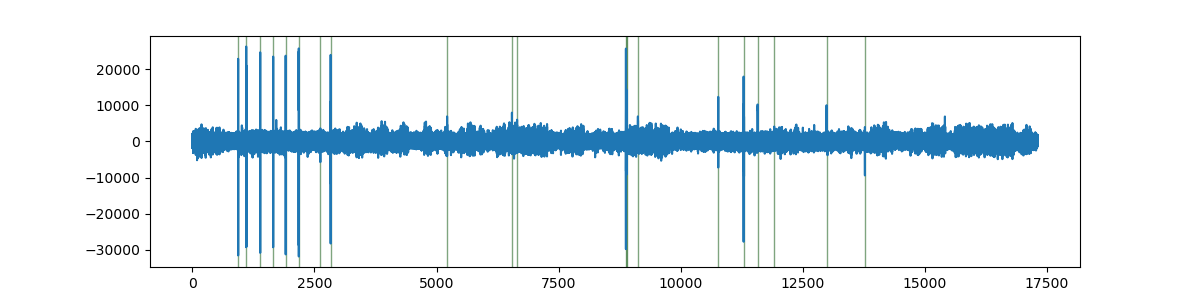

In [8]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/Rose_training_denoised.probegroup.npy saved


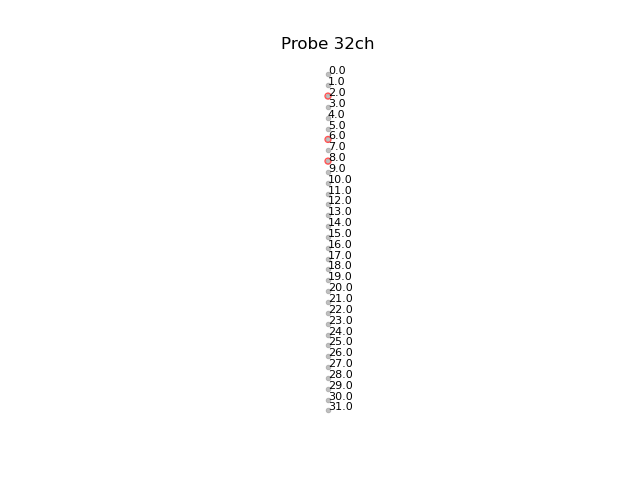

In [9]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [10]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 25

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [25]
1304 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [11]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [25]
17369 epochs remaining with durations within (0.05,0.45)


## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
913,2,2311926,2022-06-22 12:15:01.064199999,
1061,-2,2609310,2022-06-22 12:15:10.977000000,
2101,2,4709635,2022-06-22 12:16:20.987833333,
2249,-2,5007793,2022-06-22 12:16:30.926433333,
3214,2,6956054,2022-06-22 12:17:35.868466667,


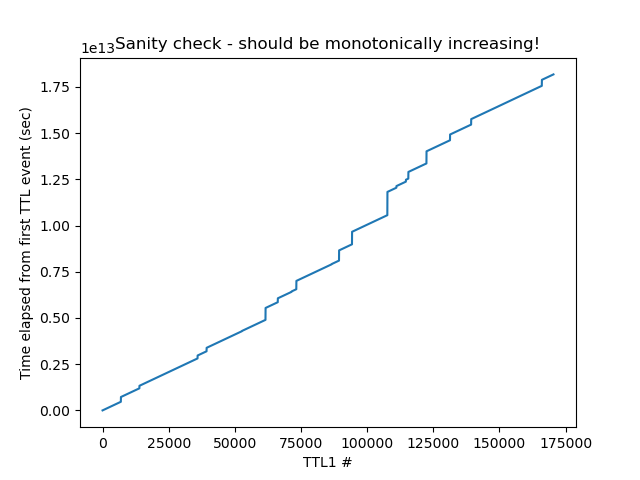

In [12]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [13]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

    # For control tone recall CS+(2)
    cs2_starts, cs2_stops, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+(2) events detected')
    print(cs2_starts.head(6))
elif "habituation" in str(sess.basepath):
     # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

5 CS- events detected
      Time (s)      Event                     Timestamp
5    61.596351  CS1_start 2022-06-22 12:15:01.388465908
7   141.519783  CS2_start 2022-06-22 12:16:21.311898497
9   216.400418  CS3_start 2022-06-22 12:17:36.192532566
11  294.323995  CS4_start 2022-06-22 12:18:54.116109637
13  369.173884  CS5_start 2022-06-22 12:20:08.965999153
6 CS+ events detected
       Time (s)      Event                     Timestamp
6    365.882572  CS1_start 2022-06-22 12:32:07.500386412
16   625.274096  CS2_start 2022-06-22 12:36:26.891909535
26   911.356316  CS3_start 2022-06-22 12:41:12.974130090
36  1177.138896  CS4_start 2022-06-22 12:45:38.756710465
46  1432.760581  CS5_start 2022-06-22 12:49:54.378395493
56  1701.590045  CS6_start 2022-06-22 12:54:23.207858737


In [14]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-06-22 12:13:44.331483-04:00
start time = 2022-06-22 12:25:48.054692-04:00
start time = 2022-06-22 12:35:27.787169-04:00
start time = 2022-06-22 13:03:02.922202-04:00
start time = 2022-06-22 13:10:06.192484-04:00
start time = 2022-06-22 13:54:58.035938-04:00
start time = 2022-06-22 14:54:42.076759-04:00
start time = 2022-06-22 15:35:41.591063-04:00
start time = 2022-06-22 15:41:43.879391-04:00
start time = 2022-06-22 16:07:27.767686-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-06-22 12:13:44.331483-04:00,start,0,0.000000,0,0.0000
1,0,2022-06-22 12:22:33.858916332-04:00,stop,15885823,529.527433,661909,529.5272
2,1,2022-06-22 12:25:48.054692-04:00,start,15885824,529.527467,661910,529.5280
3,1,2022-06-22 12:33:53.225858667-04:00,stop,30440959,1014.698633,1268373,1014.6984
4,2,2022-06-22 12:35:27.787169-04:00,start,30440960,1014.698667,1268374,1014.6992
5,2,2022-06-22 13:01:35.701802333-04:00,stop,77478399,2582.613300,3228266,2582.6128
6,3,2022-06-22 13:03:02.922202-04:00,start,77478400,2582.613333,3228267,2582.6136
7,3,2022-06-22 13:07:17.232568667-04:00,stop,85107711,2836.923700,3546154,2836.9232
8,4,2022-06-22 13:10:06.192484-04:00,start,85107712,2836.923733,3546155,2836.9240
9,4,2022-06-22 13:52:24.458050666-04:00,stop,161255679,5375.189300,6718986,5375.1888


In [15]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.6511317885, std = 0.29458161267510247
start time lag: mean = -0.6514769363333334, std = 0.294484481800417
start time lag: mean = -0.3240611524, std = 0.0001311151501803072
start time lag: mean = -0.3244041842, std = 0.00014620361483801467


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


### How to write CS+ to neuroscope event file

In [16]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/2_training/shockbox/T0000001.wav
Mean start lag time of 376.336 sec with std = 35.479 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 376.146 sec with std = 35.570 sec.


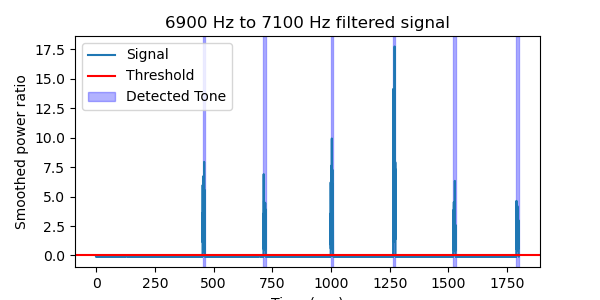

In [17]:
# Detect CS+ in audio recording.
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", plot_check=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Rose/2022_06_22_training/1_tone_habituation/restbox_tonehabit/T0000001.wav
Mean start lag time of 8.032 sec with std = 0.398 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 7.913 sec with std = 0.054 sec.


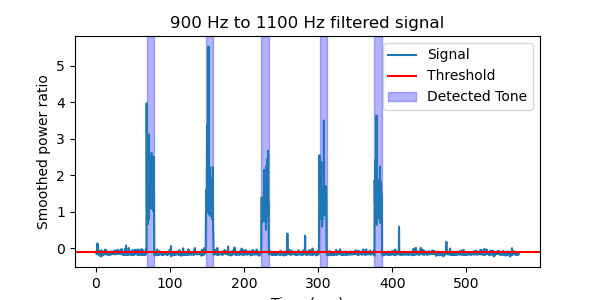

In [18]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

In [19]:
no_tone_wave = grab_usv_folder(sess.basepath, "sync")
print(no_tone_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=3, tone_length=0.5, tone_label="start_tone", plot_check=True)

NameError: name 'no_tone_wav' is not defined

## Sync recorded USV times to ephys file

In [20]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csp_wav).parent.glob(f"**/{Path(csp_wav).name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,122.001236,22.500,0.372002,1.750,0.545368,1
1,130.218658,22.375,0.496002,2.125,0.585911,1
2,161.516312,22.625,0.376007,1.875,0.502502,1
3,245.101181,22.500,0.479996,1.875,0.557878,1
4,276.072144,22.250,0.380005,2.375,0.534775,1
5,350.295563,22.500,0.459991,1.750,0.610093,1
6,361.091705,25.125,0.312012,1.875,0.525154,1
7,481.242218,22.250,0.403992,2.000,0.508441,1
8,511.899872,22.375,0.431976,1.875,0.553955,1
9,518.881287,22.500,0.323975,1.750,0.540407,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

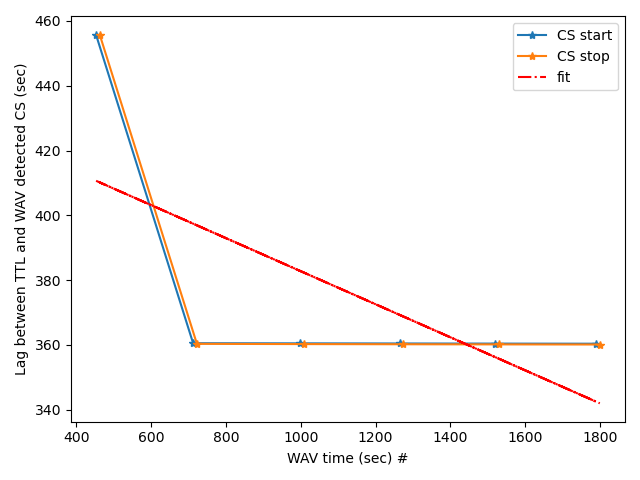

In [22]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [ ]:
def get_wav_to_dat_equation(cs_wav_epochs, cs_start_lags, cs_stop_lags, sync_df):
    """Get equation to convert cs times to dat file times"""
    pass
    # 1) Get rough alignment by identifying FIRST tone and getting datetime for each tone

    # 2) Identify any disconnect times and split into epochs of continuous recording

    # 3) Call function recursively for each epoch

    # 4) Fit a line to the lag data - in the case that there is only one point, return a Nan

    # 5) Go back and re-fit any NaN epochs using the mean slope from another epoch

    # 6) Return a dataframe with epoch start stop (from sync file) + appropriate slope and intercept to use!
    

In [103]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name
5429,2,11383517,2022-06-22 12:32:07.450566667-04:00,
259,2,1773623,2022-06-22 12:36:26.120766667-04:00,
4506,2,10356083,2022-06-22 12:41:12.202766667-04:00,
8453,2,18329564,2022-06-22 12:45:37.985466667-04:00,
12249,2,25998208,2022-06-22 12:49:53.606933333-04:00,
16241,2,34063083,2022-06-22 12:54:22.436100-04:00,


In [66]:
sync_dt_epochs._epochs.start.values[0].dtype

dtype('<M8[ns]')

In [126]:
cs_times_wav[rec_number == 2]

array([[ 712.48741573,  722.61623596],
       [ 998.60657303, 1008.76870787],
       [1264.42848315, 1274.58966292],
       [1520.0905618 , 1530.26893258],
       [1788.95101124, 1799.13477528]])

In [251]:
# Reshape inputs
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)

def fit_line_to_lags(times_wav, oe_lags_comb, use_slope=None):

    if times_wav.shape[0] > 1:
        # Fit function to approximate drift
        y = oe_lags_comb.T.reshape(-1)
        M = np.stack((np.ones_like(oe_lags_comb.reshape(-1)), times_wav.T.reshape(-1)), axis=1)
        p, res, rnk, s = lstsq(M, y)

    else:
        if use_slope is None:
            p = np.nan
        else:
            p1 = use_slope
            p0 = oe_lags_comb.mean() - p1 * times_wav.mean()
            p = (p0, p1)

    return p

# 2) Identify roughly where each tone occurred
### NRK send to long form
sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
indx_bool, _, _ = sync_dt_epochs.contains(cs_oe_start_df.datetimes.values.astype("long"))
rec_number = (np.digitize(cs_oe_start_df.datetimes.values.astype("long")[indx_bool], sync_dt_epochs.flatten()) - 1) /2
rec_number = rec_number[indx_bool].astype(int)

nepochs = len(np.unique(rec_number))

# 3-4) Call each session and fit a line
p_list = []
for nrec in np.unique(rec_number):
    p_list.append(fit_line_to_lags(cs_times_wav[rec_number == nrec], cs_lags_comb[rec_number == nrec]))
p_bool = np.array([~np.all(np.isnan(p)) for p in p_list])
pid_good = np.where(p_bool)[0]
pid_bad = np.where(~p_bool)[0]
slope_use = np.nanmean([p if np.all(np.isnan(p)) else p[1] for p in p_list])

# 5) Go back and refit
p_list_refit = []
wav_starts, wav_stops = [], []
for pid in np.unique(rec_number):

    # Get fits for each ephys recordings number
    if (pid + 1) in pid_good:  # use existing line values if good fit to begin with and > 2 points
        p_list_refit.append(p_list[pid])
    else:
        p_list_refit.append(fit_line_to_lags(cs_times_wav[rec_number == pid], cs_lags_comb[rec_number == pid], use_slope=slope_use))

    # Get time limits of WAV recordings thatcorrespond to ephys recordings
    rec_df = sync_df[sync_df.Recording == pid]
    eeg_start, eeg_stop = rec_df[rec_df.Condition == "start"].eeg_time.values, rec_df[rec_df.Condition == "stop"].eeg_time.values
    wav_starts.append((eeg_start - usv_sync_df[usv_sync_df.nrec == nrec].p0.mean()).squeeze())
    wav_stops.append((eeg_stop - usv_sync_df[usv_sync_df.nrec == nrec].p0.mean()).squeeze())
    
p_refit = np.array(p_list_refit)

# 6) Make into nice pandas array for later calculating times!
wav_sync_df = pd.DataFrame({"nrec": np.unique(rec_number), "start": wav_starts, "stop": wav_stops, 
                            "p0": p_refit[:, 0], "p1": p_refit[:, 1], "label": ""})#7
        

# 7) spit out fit of lags to each time point!
wav_sync_df



,nrec,start,stop,p0,p1,label
0,1,168.9611152132827,654.1315152132827,455.753637,-0.000169,
1,2,654.1323152132827,2222.0459152132826,360.566885,-0.000169,


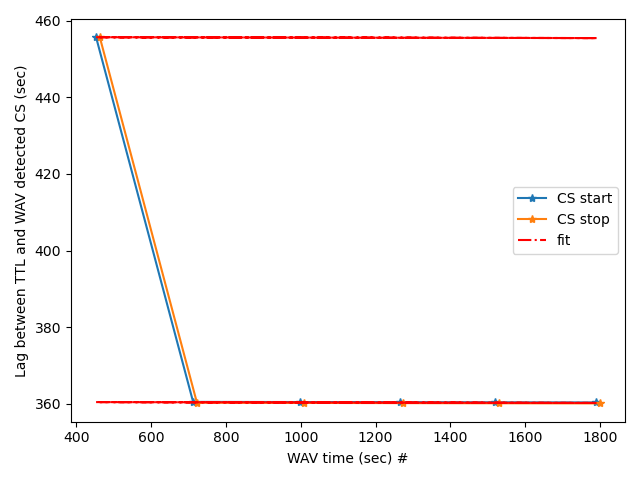

In [254]:
_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
for nrec in [1, 2]:
    hfit = ax.plot(cs_times_wav.T.reshape(-1), wav_sync_df[wav_sync_df.nrec == nrec].p0.values + 
                   wav_sync_df[wav_sync_df.nrec == nrec].p1.values*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [40]:
cs_wav_epochs._epochs

,start,stop,label
0,453.254382,463.159607,CS+
1,712.487416,722.616236,CS+
2,998.606573,1008.768708,CS+
3,1264.428483,1274.589663,CS+
4,1520.090562,1530.268933,CS+
5,1788.951011,1799.134775,CS+


In [ ]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

In [ ]:
cs_wav_epochs_aligned

Now correct that drift and find corrected lags!

In [ ]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

In [ ]:
good_calls

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)